In [ ]:
# tutorial taken from https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 6.9MB/s 
     |████████████████████████████████| 3.3MB 35.2MB/s 
     |████████████████████████████████| 901kB 50.7MB/s 


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

torch.__version__

'1.8.1+cu101'

In [ ]:
#Mount the RAW session level data: shopping.pkl
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/~Classes/NER_data/')
!ls

ner_dataset.csv


In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [ ]:
getter = SentenceGetter(data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

In [ ]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])


['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


In [ ]:
MAX_LEN = 75
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()


In [ ]:
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.6.1'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.classifier

Linear(in_features=768, out_features=18, bias=True)

In [ ]:
list(model.named_parameters())

[('bert.embeddings.word_embeddings.weight', Parameter containing:
  tensor([[-0.0005, -0.0416,  0.0131,  ..., -0.0039, -0.0335,  0.0150],
          [ 0.0169, -0.0311,  0.0042,  ..., -0.0147, -0.0356, -0.0036],
          [-0.0006, -0.0267,  0.0080,  ..., -0.0100, -0.0331, -0.0165],
          ...,
          [-0.0064,  0.0166, -0.0204,  ..., -0.0418, -0.0492,  0.0042],
          [-0.0048, -0.0027, -0.0290,  ..., -0.0512,  0.0045, -0.0118],
          [ 0.0313, -0.0297, -0.0230,  ..., -0.0145, -0.0525,  0.0284]],
         requires_grad=True)),
 ('bert.embeddings.position_embeddings.weight', Parameter containing:
  tensor([[ 0.0234,  0.0052, -0.0135,  ...,  0.0015,  0.0140,  0.0098],
          [-0.0269, -0.0048, -0.0055,  ...,  0.0059,  0.0046, -0.0055],
          [-0.0139, -0.0083,  0.0038,  ...,  0.0062,  0.0007, -0.0105],
          ...,
          [ 0.0049,  0.0155,  0.0211,  ..., -0.0096,  0.0225,  0.0138],
          [ 0.0173, -0.0214, -0.0028,  ..., -0.0240, -0.0016, -0.0129],
          

In [ ]:
param_optimizer = list(model.classifier.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]


In [ ]:
param_optimizer

[('weight', Parameter containing:
  tensor([[-1.8830e-02, -2.7549e-02,  1.7497e-02,  ...,  7.3989e-03,
           -2.1967e-02,  8.0116e-03],
          [-4.2037e-03, -1.0752e-02,  1.4816e-02,  ...,  2.1320e-02,
            1.1141e-02, -7.3708e-03],
          [-2.7440e-03,  1.1657e-02, -3.2317e-02,  ..., -1.6985e-02,
            8.0680e-03, -1.0309e-03],
          ...,
          [ 3.9532e-03, -2.4536e-02,  3.7597e-04,  ...,  1.5095e-02,
           -1.8762e-02,  3.1502e-03],
          [ 3.3038e-02,  2.5840e-02, -8.2587e-03,  ..., -2.1001e-02,
           -1.3893e-02, -1.1268e-02],
          [ 1.7309e-02, -2.8943e-05,  2.5268e-02,  ...,  1.1064e-02,
           -1.3362e-02,  8.3437e-03]], requires_grad=True)),
 ('bias', Parameter containing:
  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         requires_grad=True))]

In [ ]:
for n, p in param_optimizer:
  print(p)

Parameter containing:
tensor([[-1.8830e-02, -2.7549e-02,  1.7497e-02,  ...,  7.3989e-03,
         -2.1967e-02,  8.0116e-03],
        [-4.2037e-03, -1.0752e-02,  1.4816e-02,  ...,  2.1320e-02,
          1.1141e-02, -7.3708e-03],
        [-2.7440e-03,  1.1657e-02, -3.2317e-02,  ..., -1.6985e-02,
          8.0680e-03, -1.0309e-03],
        ...,
        [ 3.9532e-03, -2.4536e-02,  3.7597e-04,  ...,  1.5095e-02,
         -1.8762e-02,  3.1502e-03],
        [ 3.3038e-02,  2.5840e-02, -8.2587e-03,  ..., -2.1001e-02,
         -1.3893e-02, -1.1268e-02],
        [ 1.7309e-02, -2.8943e-05,  2.5268e-02,  ...,  1.1064e-02,
         -1.3362e-02,  8.3437e-03]], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)


In [ ]:
optimizer_grouped_parameters

[{'params': [Parameter containing:
   tensor([[-1.8830e-02, -2.7549e-02,  1.7497e-02,  ...,  7.3989e-03,
            -2.1967e-02,  8.0116e-03],
           [-4.2037e-03, -1.0752e-02,  1.4816e-02,  ...,  2.1320e-02,
             1.1141e-02, -7.3708e-03],
           [-2.7440e-03,  1.1657e-02, -3.2317e-02,  ..., -1.6985e-02,
             8.0680e-03, -1.0309e-03],
           ...,
           [ 3.9532e-03, -2.4536e-02,  3.7597e-04,  ...,  1.5095e-02,
            -1.8762e-02,  3.1502e-03],
           [ 3.3038e-02,  2.5840e-02, -8.2587e-03,  ..., -2.1001e-02,
            -1.3893e-02, -1.1268e-02],
           [ 1.7309e-02, -2.8943e-05,  2.5268e-02,  ...,  1.1064e-02,
            -1.3362e-02,  8.3437e-03]], requires_grad=True),
   Parameter containing:
   tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          requires_grad=True)]}]

In [ ]:
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters_full = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

In [ ]:
optimizer_grouped_parameters_full

[{'params': [Parameter containing:
   tensor([[-1.8830e-02, -2.7549e-02,  1.7497e-02,  ...,  7.3989e-03,
            -2.1967e-02,  8.0116e-03],
           [-4.2037e-03, -1.0752e-02,  1.4816e-02,  ...,  2.1320e-02,
             1.1141e-02, -7.3708e-03],
           [-2.7440e-03,  1.1657e-02, -3.2317e-02,  ..., -1.6985e-02,
             8.0680e-03, -1.0309e-03],
           ...,
           [ 3.9532e-03, -2.4536e-02,  3.7597e-04,  ...,  1.5095e-02,
            -1.8762e-02,  3.1502e-03],
           [ 3.3038e-02,  2.5840e-02, -8.2587e-03,  ..., -2.1001e-02,
            -1.3893e-02, -1.1268e-02],
           [ 1.7309e-02, -2.8943e-05,  2.5268e-02,  ...,  1.1064e-02,
            -1.3362e-02,  8.3437e-03]], requires_grad=True)],
  'weight_decay_rate': 0.01},
 {'params': [Parameter containing:
   tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          requires_grad=True)], 'weight_decay_rate': 0.0}]

In [ ]:
[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)]

[Parameter containing:
 tensor([[-0.0553,  0.0048, -0.0183,  ..., -0.0008,  0.0213,  0.0119],
         [ 0.0105, -0.0166,  0.0144,  ...,  0.0109, -0.0366,  0.0104],
         [-0.0235, -0.0289,  0.0029,  ..., -0.0445, -0.0230, -0.0103],
         ...,
         [-0.0148, -0.0193,  0.0279,  ...,  0.0277, -0.0016,  0.0101],
         [ 0.0033, -0.0404,  0.0132,  ..., -0.0135, -0.0332,  0.0141],
         [-0.0295,  0.0054, -0.0173,  ..., -0.0264, -0.0156,  0.0143]],
        requires_grad=True)]

In [ ]:
model.cuda()


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=1150dec55328a5abc7d62507b8f4fd7418cff974c3d760d43f8515cbe4fdceff
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score


In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()



Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.10930796319672671



Epoch:  33%|███▎      | 1/3 [06:26<12:53, 386.90s/it]

Validation loss: 0.12388029103477796
Validation Accuracy: 0.9610026020223312



Average train loss: 0.0817299179644431



Epoch:  67%|██████▋   | 2/3 [12:53<06:26, 386.86s/it]

Validation loss: 0.12993270757297676
Validation Accuracy: 0.9621224597345278

Average train loss: 0.0706528720713108



Epoch: 100%|██████████| 3/3 [19:19<00:00, 386.53s/it]

Validation loss: 0.12993270757297676
Validation Accuracy: 0.9621224597345278



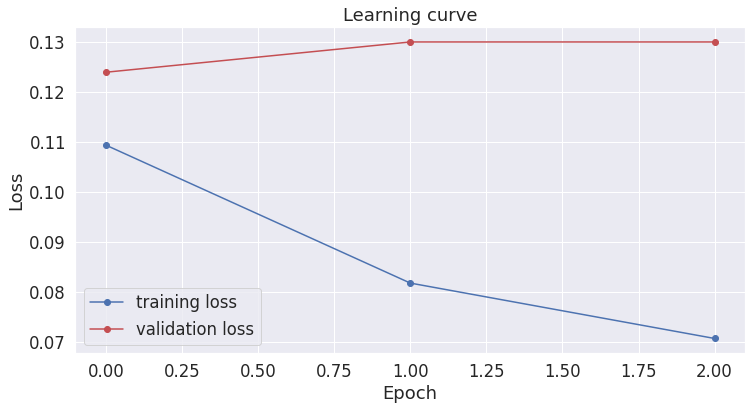

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
test_sentence = """
Divy Murli's tweets began just moments after a CNN report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""


In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()


In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
B-per	Divy
I-per	Murli
O	'
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	CNN
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]
